In [1]:
from typing import List, Mapping, Callable
from itertools import zip_longest
from textwrap import dedent

from ipywidgets import interactive, FloatSlider
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import DataRange1d, LinearAxis, ColumnDataSource

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

output_notebook()

Loading BokehJS ...

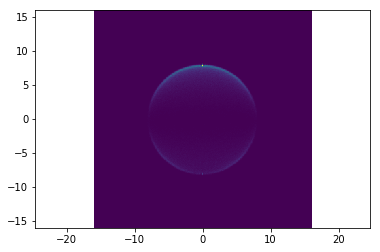

In [2]:
# Generate dist
def init_dist(beta: List[float], n: int = 1001) -> Mapping[str, np.ndarray]:
    x = np.linspace(-1, 1, n)
    fx = Legendre([1, *beta])(x)
    return {
        'x': x,
        'px': fx / fx.sum(),
    }


beta = [1, 1.5, 0.5, -0.5]
dist = init_dist(beta)


# Generate samples
def init_smp(
    n: int, r: float, sigma: float, x: float, px: float,
) -> Mapping[str, np.ndarray]:
    r = normal(loc=r, scale=sigma, size=n)
    z = r * choice(x, p=px, size=n)
    phi = 2 * np.pi * rand(n)
    x = (r ** 2 - z ** 2) ** 0.5 * np.cos(phi)
    y = (r ** 2 - z ** 2) ** 0.5 * np.sin(phi)
    return {
        'x': x,
        'y': y,
        'z': z,
    }


smp = init_smp(n=1000000, r=8, sigma=0.1, **dist)

# Generate projected image from the samples
zedges = np.linspace(-16, 16, 321)
img, *_ = np.histogram2d(smp['x'], smp['z'], bins=[zedges, zedges])

plt.figure()
plt.pcolormesh(zedges, zedges, img.T)
plt.axis("equal")
plt.show()

In [3]:
def transformer(
    hist: np.ndarray, xedges: np.ndarray, yedges: np.ndarray,
) -> Callable[..., np.ndarray]:
    f = interp(hist, xedges, yedges)

    def ret(ph: float = 0, m: float = 0, k: float = 1, th: float = 0,
            x0: float = 0, y0: float = 0) -> np.ndarray:
        mat = mrot(ph) @ mrot(-th) @ mhorshear(m) @ msqueeze(k) @ mrot(th)
        g = transpose_linearly(f, mat, u0=np.array([x0, y0]))
        return tohist(g, xedges, yedges)
    return ret
        

def analysis(
    hist: np.ndarray,
    zedges: np.ndarray, redges: np.ndarray, thedges: np.ndarray,
    n: int,
) -> dict:
    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(hist, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(
        transpose_to_drdomega(sliced), redges, thedges,
    )  # (r, th) -> intensity
    hist_indrdth = tohist(
        transpose_to_drdth(sliced), redges, thedges,
    )  # (r, th) -> intensity
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.T, thedges, n,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return {
        "r": (redges[1:] + redges[:-1]) / 2,
        "dist": hist_indrdth.sum(1),
        **{f"beta{i}": coeff[i]/coeff[0] for i in range(1, n)},
    }


transformed_by = transformer(gaussian_filter(img, 3), zedges, zedges)
redges, thedges = np.linspace(0, 16, 161), np.linspace(-np.pi, np.pi, 61)
n = 6
r = (redges[1:] + redges[:-1]) / 2
d = ColumnDataSource(data={
    "_r": r,
    "_dist": 0 * r,
    **{f"_beta{i}": 0 * r for i in range(1, n)},
})


@interactive
def plotit(
    x0 = FloatSlider(0, min=-2, max=2, step=0.05),
    y0 = FloatSlider(0, min=-2, max=2, step=0.05),
    th = FloatSlider(0, min=-3, max=3, step=0.05),
    k = FloatSlider(1, min=0.99, max=1.01, step=0.001),
    m = FloatSlider(0, min=-0.01, max=0.01, step=0.001),
    ph = FloatSlider(0, min=-3, max=3, step=0.05),
):
    for key, v in analysis(transformed_by(
        ph=ph, m=m, k=k, th=th, x0=x0, y0=y0,
    ), zedges, redges, thedges, n).items():
        d.data[f"_{key}"] = v
    print(dedent(f"""\
        x0: {x0: 8.3f}
        y0: {y0: 8.3f}
        th: {th: 8.3f}
         k: {k: 8.3f}
         m: {m: 8.3f}
        ph: {ph: 8.3f}\
    """))
    push_notebook()

In [4]:
p = figure(x_range=[0, 16], y_range=[-1, 4])
p.add_layout(LinearAxis(y_range_name="extra_y"), "left")
p.extra_y_ranges = {"extra_y": DataRange1d()}
p.line("_r", "_beta1", source=d, color="#1f77b4", legend="beta1")
p.line("_r", "_beta2", source=d, color="#ff7f0e", legend="beta2")
p.line("_r", "_beta3", source=d, color="#2ca02c", legend="beta3")
p.line("_r", "_beta4", source=d, color="#d62728", legend="beta4")
p.line("_r", "_dist", source=d, y_range_name="extra_y", color="black", legend="dist")
p.legend.click_policy = "hide"
show(p, notebook_handle=True)
plotit

interactive(children=(FloatSlider(value=0.0, description='x0', max=2.0, min=-2.0, step=0.05), FloatSlider(valu…